# Setup

In [28]:
install.packages("dplyr")
install.packages("lme4")
install.packages("GGally")
install.packages("Matrix")
install.packages("dplyr")
install.packages("emmeans")
install.packages("magrittr")


The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages

The downloaded binary packages are in
	/var/folders/0g/qk_0swpd4b74wbh299030k440000gn/T//RtmphLoaRz/downloaded_packages


In [31]:
format_model_info <- function(model, modelname) {
  aic <- AIC(model)
  bic <- BIC(model)
  
  cat(sprintf("For %s AIC=%.0f, BIC=%.0f\n", modelname, aic, bic))
}


# Read in and explore data

In [34]:
fishes_all <- read.csv("input/finresoct.csv")
dplyr::count(fishes_all, info, sort = TRUE)
fishes <- subset(fishes_all, info != 'error') # remove data where we made experimental mistakes

#preprocessing
fishes$abs10prev <-abs(fishes$stable10prev)
fishes$abs10post <-abs(fishes$stable10after)
fishes$abs10 <- fishes$abs10 + 0.00001 # there are some values equal 0 we cannto model gamm with that so we shift all ever so slightly

info,n
<chr>,<int>
dir_change,62
no_reaction,24
swim_off,24
unstable,24
error,7


[1] 12.84412

[1] 5.180552

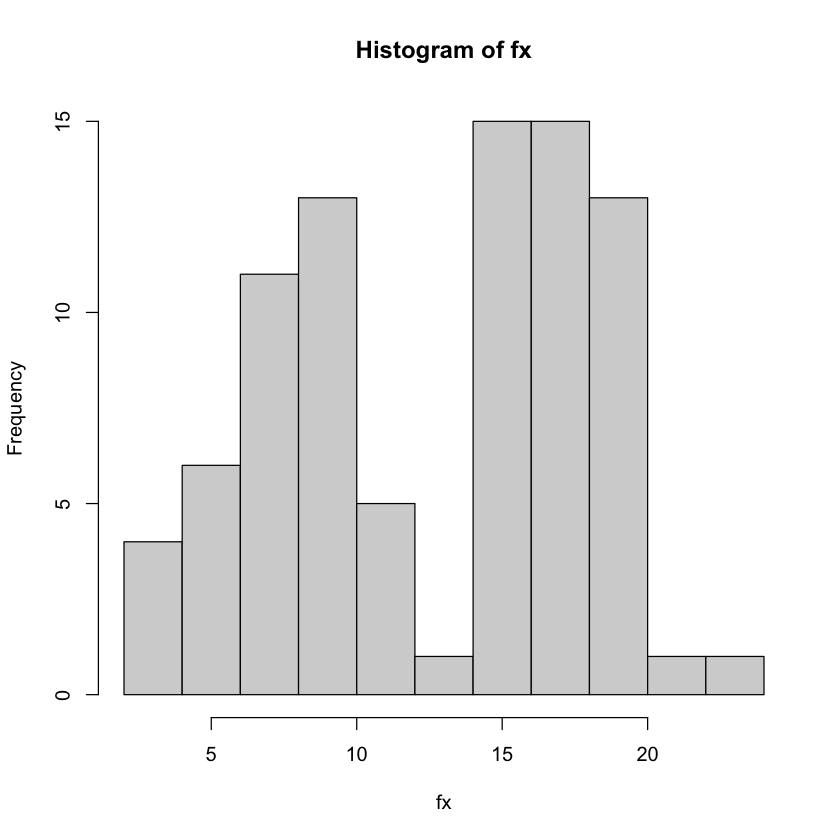

In [5]:
#What were the flow condition at the point where fish has been holding.
#average of all measurements before
flowpre <- subset(fishes, !is.na(abs10prev))
flowpost <- subset(fishes, !is.na(abs10post)) #could also look at the flow at this point after
#fx <- c(flowpre$abs10prev, flowpost$abs10post)
fx <- c(flowpre$abs10prev)

mean(fx)
sd(fx)
hist(fx)
#the distribution is really bimodal, interesting?

# Question 1: What is the behaviour response of stationary salmon smolts to switching current?

As you can see we are defining a success as dir_change, no_reaction as a failure and if fish is unstable or swims off, it is ambivalent (dk == don't known). 

We were able to judge reaction in 86 fish (64% of collected data points).
Out of those 86 fish, 62 changed direction (72%)

Changing directional water flow caused “Change of direction” or “No reaction” in 86 fish (64% of all fish successfully tested), while for 48 fish (36%) reaction was “Other behaviours”: fish were either in movement during the flow reversal (“Movement”) or did not change direction when initiating movement (“Swim off”) (see Table 1). None of the fish exhibited negative rheotaxis before flow reversal. Change of direction was the most common response to flow direction change across all three fish groups, displayed by 72% of the fish which behaviour can be classified (62 individuals) from across all trials (Figure 1). The proportion of trials where the response was “Other behaviours” was lowest in wild smolts while it was similar in both types of farmed fish (Figure 2). A binomial model with directional change/no reaction as the response variable, with and without fish group as an explanatory factor, showed that there was no significant effect of fish group (ANOVA: Chi-square = 3.98, df = 2, p=0.137, models fit: BIC=111 AIC=104 with fish type variable and BIC =106, AIC=104 without). 

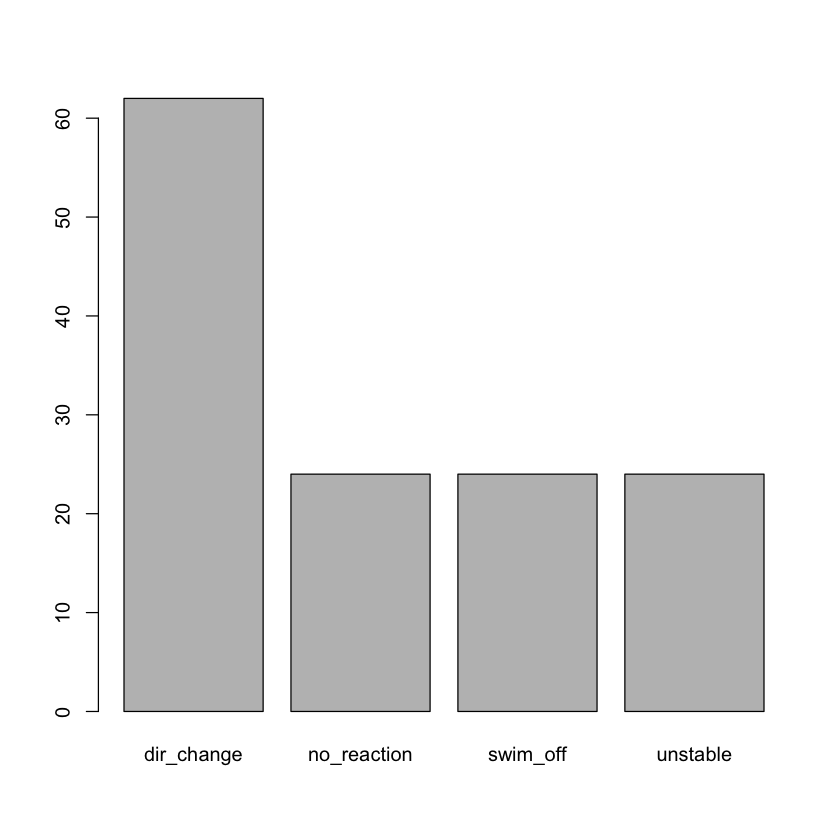

In [8]:
plot(factor(fishes$info))

In [18]:
library(lme4)
library(GGally)

fishesknown <- subset(fishes, success != 'dk')

issuc <- function(x) {
  if (x == 'yes') {
    1
  } else {
    0
  }
}


#prepare binary vector for success
fishesknown$binres <- sapply(fishesknown$success, issuc) # might not be necessary

In [19]:
modelreacted1 <- glm(binres ~ 1,fishesknown,family='binomial') 
modelreacted2 <- glm(binres ~ fishtype,fishesknown,family='binomial') 

#The following might be a way to compensating for different flow but because it is not really independent 
#it wont work. Anova tells us there is no point ofc
modelreacted5 <- glm(binres ~ fishtype * fsdir,fishesknown,family='binomial') 
modelreacted6 <- glm(binres ~ fsdir,fishesknown,family='binomial') 

In [25]:
anova(modelreacted2, test="LRT") # Testing if fishtype is a significant component of our wee model
anova(modelreacted5, test="LRT") 
anova(modelreacted6, test="LRT")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,85,101.83649,NA
fishtype,2,3.982236,83,97.85425,0.1365427


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,85,101.83649,NA
fishtype,2,3.98223566,83,97.85425,0.1365427
fsdir,4,3.31808270,79,94.53617,0.5060723
fishtype:fsdir,1,0.07572934,78,94.46044,0.7831705


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,85,101.83649,NA
fsdir,5,4.387354,80,97.44913,0.495095


In [32]:
#*IF* we found that it is significant (anova/an-dev) to include fishtype
format_model_info(modelreacted1, "null model")
format_model_info(modelreacted2, "with fish type")


For null model AIC=104, BIC=106
For with fish type AIC=104, BIC=111


# Question 3: Does fish type or flow conditions affect the flow rate at which fish turns?

### Mean values from gamma the model
Using Gamma-distrubted GLM model we estimate the mean minimum threshold flow (Vmin) for directional change across all three fish groups was 8.9 cm/s (95% CI: 7.7,10.4) (Figure 2). The mean Vmin for the two groups of farmed fish were 8.5 (95% CI: 6.7,10.9) cm/s for the cage farm origin smolts and 7.3 (95% CI: 5.8,9.2) cm/s for the tank, farm origin fish. The mean Vmin for the wild fish was slightly higher at 12.0 (95% CI: 9.2,15.6) cm/s. 

In [68]:
fs <- subset(fishes, success == 'yes') #looking only at sucessful fish, our superstars
fs$fishtype <- as.factor(fs$fishtype)

# List of fish types
fishtypes <- c('wild', 'farmed_loch', 'farmed_in')

for (type in fishtypes) {
  cat("\nResults for fishtype:", type, "\n")
  
  fsx <- subset(fs, fishtype == type)
  
  # Fit gamma distribution
  mmodel <- glm(abs10 ~ 1, fsx, family = Gamma(link = "log"))
  
  # Calculate estimates and confidence intervals
  cm <- mmodel$family$linkinv(mmodel$coef[[1]])
  cup <- mmodel$family$linkinv(summary(mmodel)$coefficients[,1] + 1.96 * summary(mmodel)$coefficients[,2])
  cdo <- mmodel$family$linkinv(summary(mmodel)$coefficients[,1] - 1.96 * summary(mmodel)$coefficients[,2])
  
  # Print results
  cat(sprintf("Estimated mu: %.4f\n", cm))
  cat(sprintf("Lower 95%% CI: %.4f\n", cdo))
  cat(sprintf("Upper 95%% CI: %.4f\n", cup))
}


Results for fishtype: wild 
Estimated mu: 11.9967
Lower 95% CI: 9.2394
Upper 95% CI: 15.5767

Results for fishtype: farmed_loch 
Estimated mu: 8.5380
Lower 95% CI: 6.7116
Upper 95% CI: 10.8614

Results for fishtype: farmed_in 
Estimated mu: 7.3182
Lower 95% CI: 5.8263
Upper 95% CI: 9.1921


In [69]:
modelflowA <- glm(abs10 ~ 1,fs,family=Gamma(link="log"))
modelflowA$family$linkinv(modelflowA$coef[[1]])

cm <- modelflowA$family$linkinv(modelflowA$coef[[1]])
cup <- modelflowA$family$linkinv(summary(modelflowA)$coefficients[,1]+1.96*summary(modelflowA)$coefficients[,2])
cdo <- modelflowA$family$linkinv(summary(modelflowA)$coefficients[,1]-1.96*summary(modelflowA)$coefficients[,2])

#95% confidence limits
print(paste('estimuted mu is ', cm))
print(paste('down 95% int ', cup))
print(paste('up 95%', cdo))

[1] 8.941945

[1] "estimuted mu is  8.94194548404267"
[1] "down 95% int  10.3721658199828"
[1] "up 95% 7.70893855992399"


### Different complexity models
The full model including flow value at the point of holding and its interactions with fish group showed no effect of fish group on the minimum flow velocity required to initiate a change in orientation towards the new current direction. However, an ANOVA analysis with Likelihood Ratio Test implied that fish group is a significant covariate (Chi-square = 2.231, df = 2, p=0.031) while flow velocity at the point of holding or its interaction with fish type are not (Chi-square = 0.096, df = 1, p=0.59 and Chi-square = 0.451, df = 2, p =0.51, respectively). 

In [93]:
#Taking previous holding conditions into consideration
modelflowC <- glm(abs10 ~ fishtype + abs10prev + abs10prev * fishtype,fs,family=Gamma(link="log"))

#modelling as fixed effect
summary(modelflowC)
anova(modelflowC, test='LRT')



Call:
glm(formula = abs10 ~ fishtype + abs10prev + abs10prev * fishtype, 
    family = Gamma(link = "log"), data = fs)

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)   
(Intercept)                    2.36841    0.85662   2.765   0.0077 **
fishtypefarmed_loch           -0.16092    0.91725  -0.175   0.8614   
fishtypefarmed_in             -0.77028    0.91053  -0.846   0.4012   
abs10prev                      0.00708    0.05149   0.138   0.8911   
fishtypefarmed_loch:abs10prev -0.01158    0.05594  -0.207   0.8367   
fishtypefarmed_in:abs10prev    0.03695    0.06104   0.605   0.5474   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3322538)

    Null deviance: 47.875  on 61  degrees of freedom
Residual deviance: 45.016  on 56  degrees of freedom
AIC: 401.27

Number of Fisher Scoring iterations: 8


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,61,47.87511,NA
fishtype,2,2.31212224,59,45.56298,0.0308243
abs10prev,1,0.09644935,58,45.46654,0.5900359
fishtype:abs10prev,2,0.45060760,56,45.01593,0.5075766


In [112]:
#Removing interactions:
modelflowCx <- glm(abs10 ~ fishtype + abs10prev,fs,family=Gamma(link="log"))
summary(modelflowCx)
anova(modelflowCx, test='LRT')



Call:
glm(formula = abs10 ~ fishtype + abs10prev, family = Gamma(link = "log"), 
    data = fs)

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.90403    0.18910  10.069  2.4e-14 ***
fishtypewild         0.42541    0.23023   1.848   0.0697 .  
fishtypefarmed_loch  0.10986    0.18902   0.581   0.5633    
abs10prev            0.00946    0.01685   0.561   0.5766    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3208047)

    Null deviance: 47.875  on 61  degrees of freedom
Residual deviance: 45.467  on 58  degrees of freedom
AIC: 397.95

Number of Fisher Scoring iterations: 7


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,61,47.87511,NA
fishtype,2,2.31212224,59,45.56298,0.02722475
abs10prev,1,0.09644935,58,45.46654,0.58347638


In [97]:
#only fishtype
fs$fishtype <- relevel(fs$fishtype, ref = "farmed_in")
#fs$fishtype <- relevel(fs$fishtype, ref = "farmed_loch")
#fs$fishtype <- relevel(fs$fishtype, ref = "wild")
modelflowB <- glm(abs10 ~ fishtype,fs,family=Gamma(link="log"))


#So just adding fishtype makes sense
summary(modelflowB)
anova(modelflowB, test='LRT')



Call:
glm(formula = abs10 ~ fishtype, family = Gamma(link = "log"), 
    data = fs)

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9904     0.1211  16.439   <2e-16 ***
fishtypewild          0.4943     0.1902   2.599   0.0118 *  
fishtypefarmed_loch   0.1542     0.1660   0.929   0.3568    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3224869)

    Null deviance: 47.875  on 61  degrees of freedom
Residual deviance: 45.563  on 59  degrees of freedom
AIC: 396.1

Number of Fisher Scoring iterations: 6


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,61,47.87511,NA
fishtype,2,2.312122,59,45.56298,0.02774136


In [113]:
format_model_info(modelflowC, "full model")
format_model_info(modelflowCx, "full model without interactions")
format_model_info(modelflowB, "fishtype only")
format_model_info(modelflowA, "null model")

For full model AIC=401, BIC=416
For full model without interactions AIC=398, BIC=409
For fishtype only AIC=396, BIC=405
For null model AIC=396, BIC=400


### Post-hoc

,contrast,ratio,SE,df,null,t.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,farmed_in / wild,0.6100183,0.1159959,59,1,-2.5993282,0.03117674
2,farmed_in / farmed_loch,0.8571309,0.1422888,59,1,-0.9286696,0.62448260
3,wild / farmed_loch,1.4050905,0.2606002,59,1,1.8337426,0.16755676


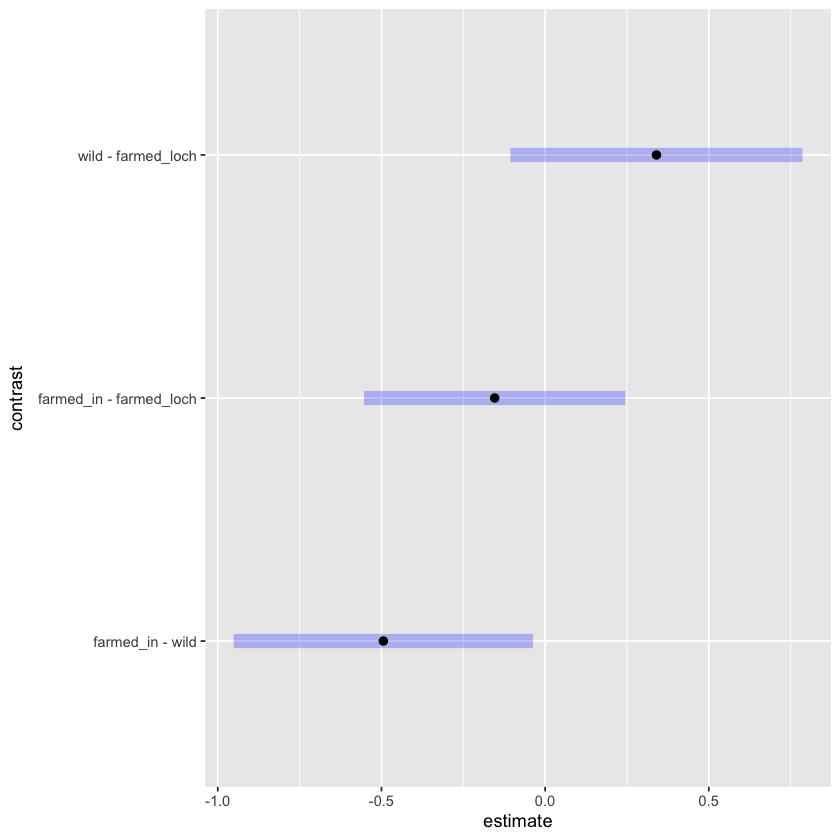

In [99]:
library(emmeans)
# Your existing code

# Perform pairwise comparisons (similar to Tukey's test)
emmeans_result <- emmeans(modelflowB, specs = "fishtype")
pairs_result <- pairs(emmeans_result, adjust = "tukey")

# If you want to see the results on the response scale (not log scale)
summary(pairs_result, type = "response")

# You can also plot the results
plot(pairs_result)

### Compare "closest"

In [114]:
fsy <- subset(fs, fs == 'high')
fsy$fishtype <- as.factor(fsy$fishtype)
fsy$fishtype <- relevel(fsy$fishtype, ref = "farmed_loch")
fsy$fishtype <- relevel(fsy$fishtype, ref = "wild")


modelflowONE <- glm(abs10 ~ fishtype + abs10prev + abs10prev * fishtype,fsy,family=Gamma(link="log"))
anova(modelflowONE,test='LRT')
summary(modelflowONE)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,29,10.264798,NA
fishtype,1,0.2019946,28,10.062804,0.4081183
abs10prev,1,0.4320769,27,9.630727,0.2263422
fishtype:abs10prev,1,0.6217333,26,9.008994,0.1467051



Call:
glm(formula = abs10 ~ fishtype + abs10prev + abs10prev * fishtype, 
    family = Gamma(link = "log"), data = fsy)

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)   
(Intercept)                    2.36841    0.80743   2.933  0.00692 **
fishtypefarmed_loch            1.56111    1.12959   1.382  0.17873   
abs10prev                      0.00708    0.04853   0.146  0.88514   
fishtypefarmed_loch:abs10prev -0.10346    0.06658  -1.554  0.13228   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.2951947)

    Null deviance: 10.265  on 29  degrees of freedom
Residual deviance:  9.009  on 26  degrees of freedom
AIC: 194.63

Number of Fisher Scoring iterations: 6


In [110]:

  # Fit gamma distribution
  mmodel <- glm(abs10 ~ 1, fsy, family = Gamma(link = "log"))
  
  # Calculate estimates and confidence intervals
  cm <- mmodel$family$linkinv(mmodel$coef[[1]])
  cup <- mmodel$family$linkinv(summary(mmodel)$coefficients[,1] + 1.96 * summary(mmodel)$coefficients[,2])
  cdo <- mmodel$family$linkinv(summary(mmodel)$coefficients[,1] - 1.96 * summary(mmodel)$coefficients[,2])
  
  # Print results
  cat(sprintf("Estimated mu: %.4f\n", cm))
  cat(sprintf("Lower 95%% CI: %.4f\n", cdo))
  cat(sprintf("Upper 95%% CI: %.4f\n", cup))

Estimated mu: 11.0883
Lower 95% CI: 9.1237
Upper 95% CI: 13.4760


In [119]:
dplyr::count(fsy, fishtype, sort = TRUE)



fishtype,n
<fct>,<int>
wild,15
farmed_loch,15
